In [1]:
import sys
sys.path.append('../utils')

from preprocessing import Preprocessor

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import random
from sklearn.model_selection import train_test_split    
from PIL import Image

import tensorflow as tf
import tensorflow.contrib.layers as layers
tf.python.control_flow_ops = tf

## Initialise the data

In [2]:
train_cats, train_dogs, train_all, test_all = Preprocessor.get_dataset_paths()

np.random.shuffle(train_all)
np.random.shuffle(test_all)

labels = [[1., 0.] if 'dog' in name else [0., 1.] for name in train_all] # labels are one hot encoded

## Example of usage

<PIL.Image.Image image mode=RGB size=64x64 at 0x7FCFE1502790>


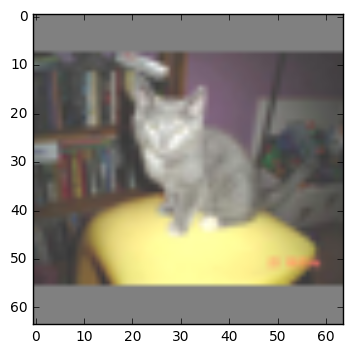

In [3]:
image_size = 64

random_index = np.random.randint(0, len(train_all))
image_path = train_all[random_index]
image = Preprocessor.get_image(image_path)

processed_image = Preprocessor.get_processed_image(image, size=image_size)
print (processed_image)

plt.imshow(processed_image)
plt.show()

def get_processed_image_from_path(path):
    image = Preprocessor.get_image(path)
    processed_image = Preprocessor.get_processed_image(image, size=image_size)
    return np.array(processed_image)

In [4]:
print (np.array(processed_image).shape)

(64, 64, 3)


In [5]:
print np.array(processed_image)[3][0]

[128 128 128]


## Model

In [6]:
from multiprocessing import Pool

In [7]:
dataset_size = 25000
train = list(Pool(8).map(get_processed_image_from_path, train_all[:dataset_size]))
labels = labels[:dataset_size] 

print train[0].shape
print len(train), len(labels)

(64, 64, 3)
25000 25000


In [20]:
class TFConvNet(object):
    def __init__(self, feature_num, class_num, is_training, step=1e-4, size=64, batch_size=100):
        self.weight_decay = 1e-3
        self.bn_params = {
            # Decay for the moving averages.
            'decay': 0.999,
            'center': True,
            'scale': True,
            # epsilon to prevent 0s in variance.
            'epsilon': 0.002,
            # None to force the updates during train_op
            'updates_collections': None,
            'is_training': is_training
        }

        self.batch_size = batch_size
        self.feature_num = feature_num
        self.class_num = class_num

        self.X = tf.placeholder(tf.float32, [None, feature_num])
        self.y_ = tf.placeholder(tf.float32, [None, class_num])

        with tf.contrib.framework.arg_scope(
                [layers.convolution2d],
                kernel_size=3, stride=1, padding='SAME', activation_fn=tf.nn.relu,
                normalizer_fn=layers.batch_norm, normalizer_params=self.bn_params,
                weights_initializer=layers.variance_scaling_initializer(),
                weights_regularizer=layers.l2_regularizer(self.weight_decay)
        ):
            self.X = tf.reshape(self.X, [-1, size, size, 3])
            self.keep_prob = tf.placeholder(tf.float32)
            
            net = layers.max_pool2d(self.X, kernel_size=2)
              
            net = layers.convolution2d(net, num_outputs=8)
            net = layers.convolution2d(net, num_outputs=8)
            net = layers.convolution2d(net, num_outputs=8)
            net = layers.max_pool2d(net, kernel_size=2)
            net = layers.relu(net, num_outputs=8)
  
            net = layers.convolution2d(net, num_outputs=16)
            net = layers.convolution2d(net, num_outputs=16)
            net = layers.convolution2d(net, num_outputs=16)
            net = layers.max_pool2d(net, kernel_size=2)
            net = layers.relu(net, num_outputs=16)
            
            net = layers.convolution2d(net, num_outputs=32)
            net = layers.convolution2d(net, num_outputs=32)
            net = layers.convolution2d(net, num_outputs=32)
            net = layers.max_pool2d(net, kernel_size=2)
            net = layers.dropout(net, keep_prob=self.keep_prob)
            net = layers.relu(net, num_outputs=32)
            
            net = layers.convolution2d(net, num_outputs=64)
            net = layers.convolution2d(net, num_outputs=64)
            net = layers.convolution2d(net, num_outputs=64)
            net = layers.max_pool2d(net, kernel_size=2)
            net = layers.dropout(net, keep_prob=self.keep_prob)
            net = layers.relu(net, num_outputs=64)

            net = layers.flatten(net, [-1, 2 * 2 * 64])
            net = layers.fully_connected(net, num_outputs=128, activation_fn=tf.nn.relu)
            net = layers.dropout(net, keep_prob=self.keep_prob)

            net = layers.fully_connected(net, num_outputs=self.class_num)
            self.y = layers.softmax(net)

        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(net, self.y_))
        self.optimizer = tf.train.RMSPropOptimizer(step).minimize(self.loss)
        
        pred = tf.equal(tf.argmax(self.y, 1), tf.argmax(self.y_, 1))
        self.acc = tf.reduce_mean(tf.cast(pred, tf.float32))

        self.sess = tf.Session()

    def train(self, X_train, y_train, X_test, y_test, epochs=2000, keep_prob=0.5):
        print("Starting to train")
        self.sess.run(tf.initialize_all_variables())
        
        batch_size = self.batch_size
        
        batch_start = 0
        batch_end = batch_start + batch_size
        
        combined = list(zip(X_train, y_train))
        random.shuffle(combined)
        X_train[:], y_train[:] = zip(*combined)
        
        for iteration in range(epochs):
            _, loss, probs = self.sess.run(
                [self.optimizer, self.loss, self.y],
                feed_dict={
                    self.X: X_train[batch_start:batch_end],
                    self.y_: y_train[batch_start:batch_end],
                    self.keep_prob: keep_prob
                }
            )

            if iteration % 100 == 0:
                train_acc = self.sess.run(
                    self.acc,
                    feed_dict={
                        self.X: X_train[batch_start:batch_end],
                        self.y_: y_train[batch_start:batch_end],
                        self.keep_prob: 1.0
                    }
                )

                val_acc = self.sess.run(
                    self.acc,
                    feed_dict={self.X: X_test, self.y_: y_test, self.keep_prob: 1.0}
                )

                print(
                    'Iteration: {}, minibatch loss: {:2.6}, train acc: {:.2%}, validation acc: {:.2%}'.format(
                        iteration, loss, train_acc, val_acc)
                )

                if val_acc >= 0.8:
                    print('Validation acc is great')
                    break

            batch_start = batch_end
            batch_end += batch_size

            if batch_end > len(X_train):
                batch_start = 0
                batch_end = batch_start + batch_size
                
                combined = list(zip(X_train, y_train))
                random.shuffle(combined)
                X_train[:], y_train[:] = zip(*combined)

        print("Training ended")
    
    def generate_submission(self, test_x, file_name='submission.csv'):
        print('Preparing to generate submission.csv')
        predict = tf.argmax(self.y, 1)

        predictions = []
        for i in range(0, len(test_x)):
            
            batch = test_x[i * self.batch_size: (i + 1) * self.batch_size]
            
            if len(batch) == 0:
                break
            
            predict_batch = self.sess.run([predict], feed_dict={self.X: batch, self.keep_prob: 1.0})

            predictions.extend(list(predict_batch[0]))

        print(len(test_x), len(predictions))
        np.savetxt(
            file_name, np.c_[range(1, len(test_x) + 1), predictions],
            delimiter=',', header='id,Label', comments='', fmt='%d'
        )

        print('saved: %s' % file_name)

In [21]:
class_num = 2
feature_number = image_size * image_size * 3

conv_net = TFConvNet(feature_number, class_num, False, size=image_size,  batch_size=100, step=5e-5) 

In [22]:
train_x, test_x, train_y, test_y = train_test_split(train, labels, test_size=0.3)
conv_net.train(train_x, train_y, test_x, test_y, epochs=150000)

Starting to train
Iteration: 0, minibatch loss: 13.2966, train acc: 50.00%, validation acc: 50.21%
Iteration: 100, minibatch loss: 0.846824, train acc: 54.00%, validation acc: 50.21%
Iteration: 200, minibatch loss: 0.688285, train acc: 51.00%, validation acc: 50.21%
Iteration: 300, minibatch loss: 0.693147, train acc: 51.00%, validation acc: 50.21%
Iteration: 400, minibatch loss: 0.693147, train acc: 42.00%, validation acc: 50.21%
Iteration: 500, minibatch loss: 0.693147, train acc: 49.00%, validation acc: 50.21%
Iteration: 600, minibatch loss: 0.693147, train acc: 55.00%, validation acc: 50.21%
Iteration: 700, minibatch loss: 0.693147, train acc: 45.00%, validation acc: 50.21%
Iteration: 800, minibatch loss: 0.693147, train acc: 50.00%, validation acc: 50.21%
Iteration: 900, minibatch loss: 0.693147, train acc: 57.00%, validation acc: 50.21%
Iteration: 1000, minibatch loss: 0.686794, train acc: 58.00%, validation acc: 50.21%
Iteration: 1100, minibatch loss: 0.693147, train acc: 57.00%

In [10]:
test = list(Pool(8).map(get_processed_image_from_path, test_all))

In [11]:
print test[0].shape

(32, 32, 3)


In [12]:
conv_net.generate_submission(test)

Preparing to generate submission.csv
(12500, 12500)
saved: submission.csv
